In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import re
import pickle
import seaborn as sns
print(sns.color_palette("deep").as_hex())
plt.style.use('seaborn-v0_8-deep')

OPTIMS = ['rmiso','onmf', 'psgd', 'adagrad', 'mu']

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    #"font.size"   : 15,
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": "\n".join([
        "\\usepackage{units}",  # load additional packages
        "\\usepackage{metalogo}",
        "\\usepackage{unicode-math}",  # unicode math setup
        r"\setmathfont{xits-math.otf}",
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble
    ])
})


['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']


In [2]:
def get_curve_data(dataset="mnist"):
    folder_path = 'curve'
    filenames = [name for name in os.listdir(folder_path) if name.startswith(dataset.lower())]
    #curvenames = [name.rsplit('.', 1)[0] for name in os.listdir(folder_path) if name.startswith(dataset.lower())]
    paths = [os.path.join(folder_path, name) for name in filenames]
    optims = [name.split('-')[1] for name in filenames]
    algs = [name.split('-')[-1] for name in filenames]
    nodes = [int(name.split('-')[-2][5:]) for name in filenames]
    hps = [name.split('-')[2:-5] if name.split('-')[-5].startswith("alpha") else name.split('-')[2:-4] for name in filenames]
    alphas = [float(name.split('-')[-5][5:]) if name.split('-')[-5].startswith("alpha") else float(name.split('-')[-4][5:]) for name in filenames]
    seps = ["sep_classes" in name.split('-') for name in filenames]
    return [{"optim": op, "alg": alg, "nodes": n, "hyp_params": hp, "sep": sep, "alpha": alpha, "curve": pickle.load(open(fp, 'rb'))} for op, alg, n, hp, sep, alpha, fp in zip(optims, algs, nodes, hps, seps, alphas, paths)]

In [3]:
def order_labels(labels, handels):
    i = 0
    while labels[i].startswith("RMISO"):
        i += 1
    if labels[i] != "MISO":
        pass
    else:
        i_0 = i
        temp_l, temp_h = labels[i], handels[i]
        while labels[i+1].startswith("RMISO"):
            i += 1
        for j in range(i_0, i):
            labels[j] = labels[j+1]
            handels[j] = handels[j+1]
        labels[i] = temp_l
        handels[i] = temp_h
        
    for j in range(0, i-1):
        for k in range(0, i-j-1):
            try:
                hp_left = float(re.findall("\d+\.?\d*", labels[k]).pop())
            except IndexError:
                hp_left = 0
            try:
                hp_right = float(re.findall("\d+\.?\d*", labels[k+1]).pop())
            except IndexError:
                hp_right = 0
            if hp_left < hp_right:
                temp_l, temp_h = labels[k], handels[k]
                labels[k], handels[k] = labels[k+1], handels[k+1]
                labels[k+1], handels[k+1] = temp_l, temp_h
            
        
    return handels, labels

In [4]:
def plot(dataset='mnist', ylim=(1e-1, 2), xlim=(0, 10), algorithm="uniform", nodes=200, alpha=0, optimizers=OPTIMS, plot_time=False, label_sep=False):

    curve_data = get_curve_data(dataset=dataset)
    fig, ax = plt.subplots(sharex=True, sharey=True)
    fig.set_figwidth(6)
    ax.set_ylim(ylim)
    ax.set_ylabel("Reconstruction Error")
    ax.set_xlim(xlim)
    plt.yscale("log")
    
    for optimizer in optimizers:
    
        for curve in curve_data:
            optim = curve['optim']
            alg = curve['alg']
            n = curve['nodes']
            marker = None
            sep = curve['sep']
            alph = curve['alpha']
        
            if alg == algorithm and optim == optimizer and n == nodes and sep == label_sep and alph == alpha:
                if optim == 'rmiso':
                    marker= '*'
                    rho = float(re.findall("\d+\.?\d*", curve['hyp_params'][0]).pop())
                    beta = float(re.findall("\d+\.?\d*", curve['hyp_params'][1]).pop())
                    try:
                        dr = curve['hyp_params'][3][2:]
                        dr = (dr == 'True') 
                    except IndexError:
                        dr = False
                    if rho == 0:
                        if dr:
                            label = "RMISO-DR"
                            color = '#ccb974'
                        else:
                            label = "MISO"
                            marker = 's'
                            color = '#4c72b0'
                    else:
                        if algorithm == "uniform":
                            color = '#dd8452' if (rho == 10) else '#55a868'
                            label = r"RMISO $\rho=${:g}".format(rho)
                        else :
                            color = '#dd8452' if (beta == 1) else '#55a868'
                            label = r"RMISO $\beta$={:g}".format(beta)
                else:
                    label=f"{optim.upper()}"
                    color = '#64b5cd' if optim == 'adagrad' else '#8172b3'
                    
            
                linestyle = '-' if optim == "rmiso" else ''
                loss = curve['curve']['losses']
                time = curve['curve']['times']
                if plot_time:
                    ax.set_xlabel('Elapsed Time (s)')
                    zorder = 0 if optim == "adagrad" else 1
                    ax.plot(time, loss, label=label, marker=marker, markevery=500, zorder=zorder, color=color)
                    plt.gca().tick_params(which='minor', labelleft=False)
                else:
                    ax.set_xlim((0, 6000))
                    ax.set_xlabel('Iterations')
                    zorder = 0 if optim == "adagrad" else 1
                    ax.plot(loss, label=label, marker=marker, markevery=500, zorder=zorder, color=color)
                    plt.gca().tick_params(which='minor', labelleft=False)
    
    plt.grid(ls='--', which='both') 
    
    handles,labels = plt.gca().get_legend_handles_labels()
    handles, labels = order_labels(labels, handles)
    plt.legend(handles, labels, ncol=2)
    
    node_var = "homog" if not label_sep else "hetero"
    x_axis = "time" if plot_time else "iterations"
    
    save_name = "{}_{}_{}".format(algorithm, x_axis, node_var)+".pdf"
    directory = os.path.join(os.getcwd(), 'figs')
    os.makedirs(directory, exist_ok=True)
    f_name = os.path.join(directory, save_name)
    #plt.savefig(f_name, bbox_inches="tight")

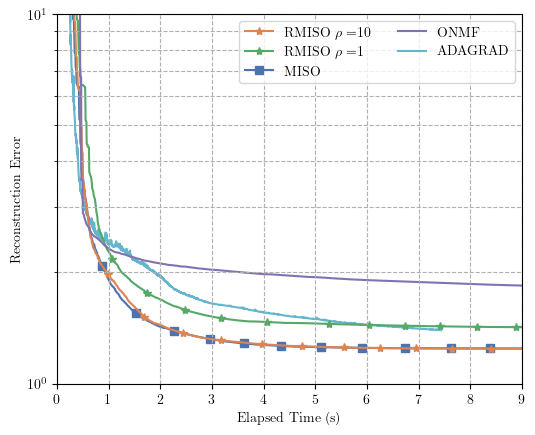

In [5]:
optims = ['rmiso','onmf', 'psgd', 'adagrad']
plot(algorithm="uniform", ylim=(1, 10), xlim=(0, 9), plot_time=True, nodes=50, optimizers=optims, alpha=0.036)

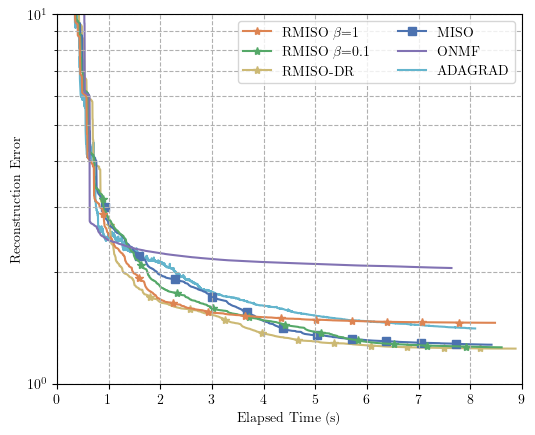

In [6]:
optims = ['rmiso','onmf', 'pgd', 'adagrad', 'mu']
#optims = ['adagr']
plot(algorithm="random_walk", ylim=(1, 10), xlim=(0, 9), nodes=50, plot_time=True, optimizers=optims, alpha=0.036)

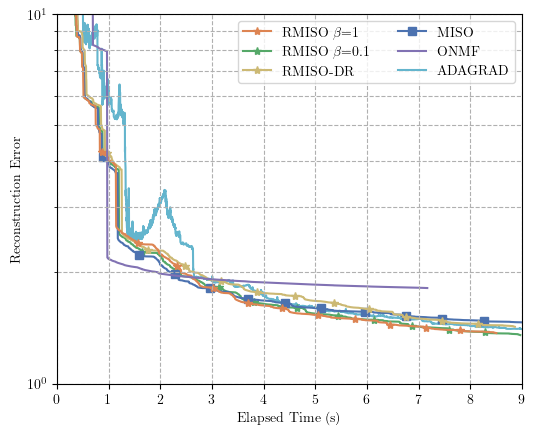

In [7]:
plot(algorithm="metropolis_hastings", ylim=(1, 10), xlim=(0, 9), nodes=50, plot_time=True, alpha=0.036)

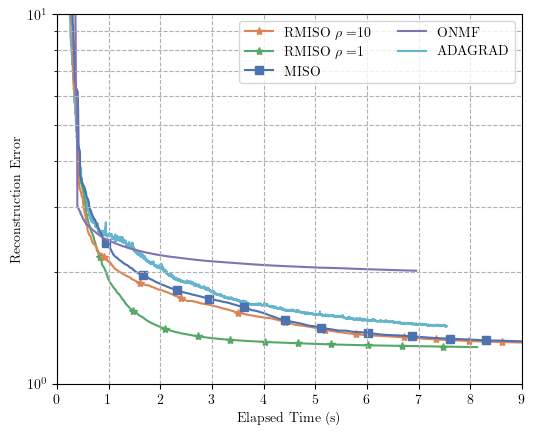

In [8]:
plot(algorithm="uniform", ylim=(1, 10), xlim=(0, 9), nodes=55, 
     alpha=0.036, plot_time=True, label_sep=True)

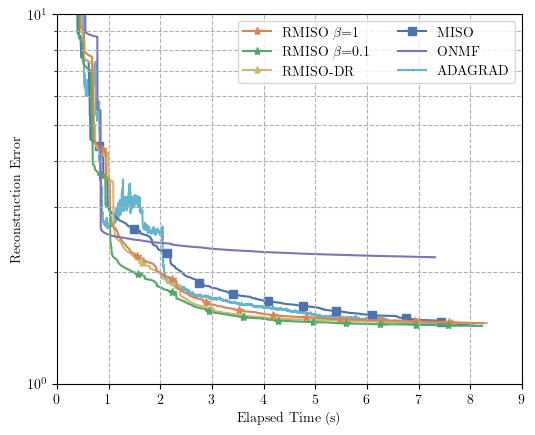

In [9]:
plot(algorithm="random_walk", ylim=(1, 10), xlim=(0, 9), nodes=55, 
     alpha=0.036, plot_time=True, label_sep=True)

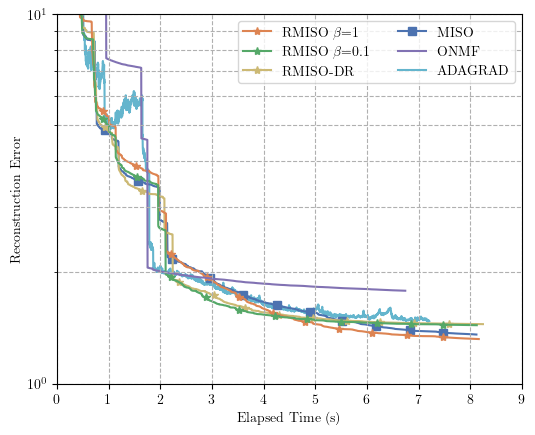

In [10]:
plot(algorithm="metropolis_hastings", ylim=(1, 10), xlim=(0, 9), nodes=55, alpha=0.036, 
     plot_time=True, label_sep=True)

In [6]:
def get_cycle_curve_data(dataset="mnist"):
    folder_path = 'curve/cycle'
    filenames = [name for name in os.listdir(folder_path) if name.startswith(dataset.lower())]
    #curvenames = [name.rsplit('.', 1)[0] for name in os.listdir(folder_path) if name.startswith(dataset.lower())]
    paths = [os.path.join(folder_path, name) for name in filenames]
    optims = [name.split('-')[1] for name in filenames]
    algs = [name.split('-')[-1] for name in filenames]
    nodes = [int(name.split('-')[-2][5:]) for name in filenames]
    hps = [name.split('-')[2:-5] if name.split('-')[-5].startswith("alpha") else name.split('-')[2:-4] for name in filenames]
    alphas = [float(name.split('-')[-5][5:]) if name.split('-')[-5].startswith("alpha") else float(name.split('-')[-4][5:]) for name in filenames]
    seps = ["sep_classes" in name.split('-') for name in filenames]
    return [{"optim": op, "alg": alg, "nodes": n, "hyp_params": hp, "sep": sep, "alpha": alpha, "curve": pickle.load(open(fp, 'rb'))} for op, alg, n, hp, sep, alpha, fp in zip(optims, algs, nodes, hps, seps, alphas, paths)]

In [7]:
def order_labels_cycle(labels, handels):
    i = 0
    while labels[i].startswith("RMISO"):
        i += 1
    if labels[i] != "MISO":
        pass
    else:
        i_0 = i
        temp_l, temp_h = labels[i], handels[i]
        while labels[i+1].startswith("RMISO"):
            i += 1
        for j in range(i_0, i):
            labels[j] = labels[j+1]
            handels[j] = handels[j+1]
        labels[i] = temp_l
        handels[i] = temp_h
        
    for j in range(0, i-1):
        for k in range(0, i-j-1):
            try:
                #hp_left = float(re.findall("\d+\.?\d*", labels[k]).pop())
                hp_left = labels[k].split("-")[1][0]
            except IndexError:
                hp_left = 'a'
            try:
                #hp_right = float(re.findall("\d+\.?\d*", labels[k+1]).pop())
                hp_right = labels[k+1].split("-")[1][0]
            except IndexError:
                hp_right = 'a'
            if hp_left >= hp_right:
                #print(hp_left)
                temp_l, temp_h = labels[k], handels[k]
                labels[k], handels[k] = labels[k+1], handels[k+1]
                labels[k+1], handels[k+1] = temp_l, temp_h
            
        
    return handels, labels

In [19]:
def plot_cycle(dataset='mnist', ylim=(1e-1, 2), xlim=(0, 10), algorithm="uniform", nodes=200, alpha=0, optimizers=OPTIMS, plot_time=False, label_sep=False):

    curve_data = get_cycle_curve_data(dataset=dataset)
    fig, ax = plt.subplots(sharex=True, sharey=True)
    fig.set_figwidth(6)
    ax.set_ylim(ylim)
    ax.set_ylabel("Reconstruction Error")
    ax.set_xlim(xlim)
    plt.yscale("log")
    
    for optimizer in optimizers:
    
        for curve in curve_data:
            optim = curve['optim']
            alg = curve['alg']
            n = curve['nodes']
            marker = None
            sep = curve['sep']
            alph = curve['alpha']
        
            if alg == algorithm and optim == optimizer and n == nodes and sep == label_sep and alph == alpha:
                if optim == 'rmiso':
                    marker= '*'
                    rho = float(re.findall("\d+\.?\d*", curve['hyp_params'][0]).pop())
                    beta = float(re.findall("\d+\.?\d*", curve['hyp_params'][1]).pop())
                    try:
                        dr = curve['hyp_params'][3][2:]
                        dr = (dr == 'True') 
                    except IndexError:
                        dr = False
                    if rho == 0:
                        if dr:
                            label = "RMISO-DR"
                            color = '#ccb974'
                        else:
                            label = "MISO"
                            marker = 's'
                            color = '#4c72b0'
                    else:
                        if algorithm == "uniform":
                            color = '#dd8452' if (rho == 10) else '#55a868'
                            label = r"RMISO $\rho=${:g}".format(rho)
                        else :
                            color = '#dd8452' if (beta == 1) else '#55a868'
                            if float(beta) != 0:
                                label = r"RMISO-DPR".format(beta)
                            else:
                                label = r"RMISO-CPR".format(rho)
                else:
                    label=f"{optim.upper()}"
                    color = '#64b5cd' if optim == 'adagrad' else '#8172b3'
                    
            
                linestyle = '-' if optim == "rmiso" else ''
                loss = curve['curve']['losses']
                time = curve['curve']['times']
                if plot_time:
                    ax.set_xlabel('Elapsed Time (s)')
                    zorder = 1 if optim == "rmiso" and label != "MISO" else 0
                    ax.plot(time, loss, label=label, marker=marker, markevery=500, zorder=zorder, color=color)
                    plt.gca().tick_params(which='minor', labelleft=False)
                else:
                    ax.set_xlim((0, 6000))
                    ax.set_xlabel('Iterations')
                    zorder = 1 if optim == "rmiso" and label != "MISO" else 0 
                    ax.plot(loss, label=label, marker=marker, markevery=500, zorder=zorder, color=color)
                    plt.gca().tick_params(which='minor', labelleft=False)
    
    plt.grid(ls='--', which='both') 
    
    handles,labels = plt.gca().get_legend_handles_labels()
    handles, labels = order_labels_cycle(labels, handles)
    plt.legend(handles, labels, ncol=2)
    
    node_var = "homog" if not label_sep else "hetero"
    x_axis = "time" if plot_time else "iterations"
    
    save_name = "cycle_{}_{}_{}".format(algorithm, x_axis, node_var)+".pdf"
    directory = os.path.join(os.getcwd(), 'figs')
    os.makedirs(directory, exist_ok=True)
    f_name = os.path.join(directory, save_name)
    #plt.savefig(f_name, bbox_inches="tight")

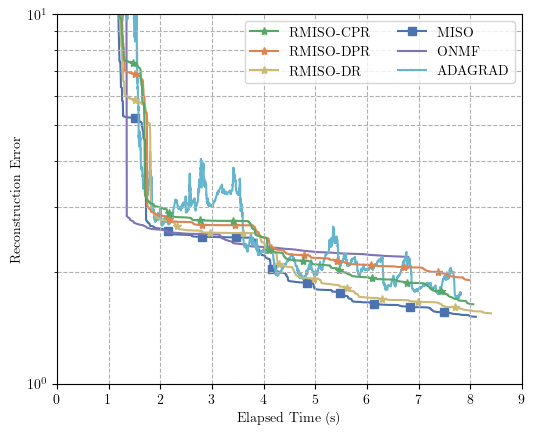

In [24]:
plot_cycle(algorithm="random_walk", ylim=(1, 10), xlim=(0, 9), nodes=55, alpha=0.036, 
     plot_time=True, label_sep=True)

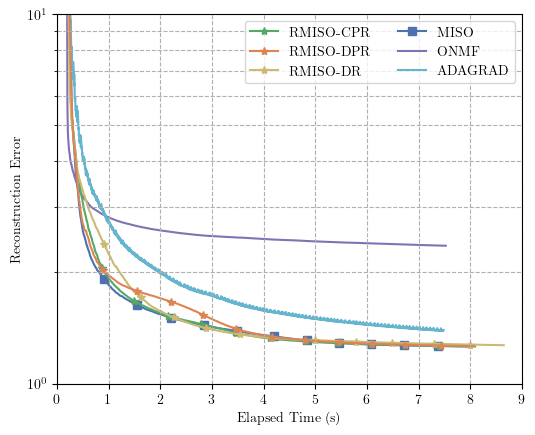

In [25]:
plot_cycle(algorithm="sequential", ylim=(1, 10), xlim=(0, 9), nodes=55, alpha=0.036, 
     plot_time=True, label_sep=True)